# Simulation and Bootstrap

Zhentao Shi

<!-- code is tested on SCRP -->


In [5]:
library(magrittr)
library(tibble)
library(plyr)
set.seed(888)

## Simulation


* check finite-sample performance of asymptotic approximation
* bootstrap, a data-driven inference procedure
* generate non-standard distributions; 
* approximate integrals with no analytic expressions.


## Appetizer

calculating $\pi$.

Loading required package: plotrix



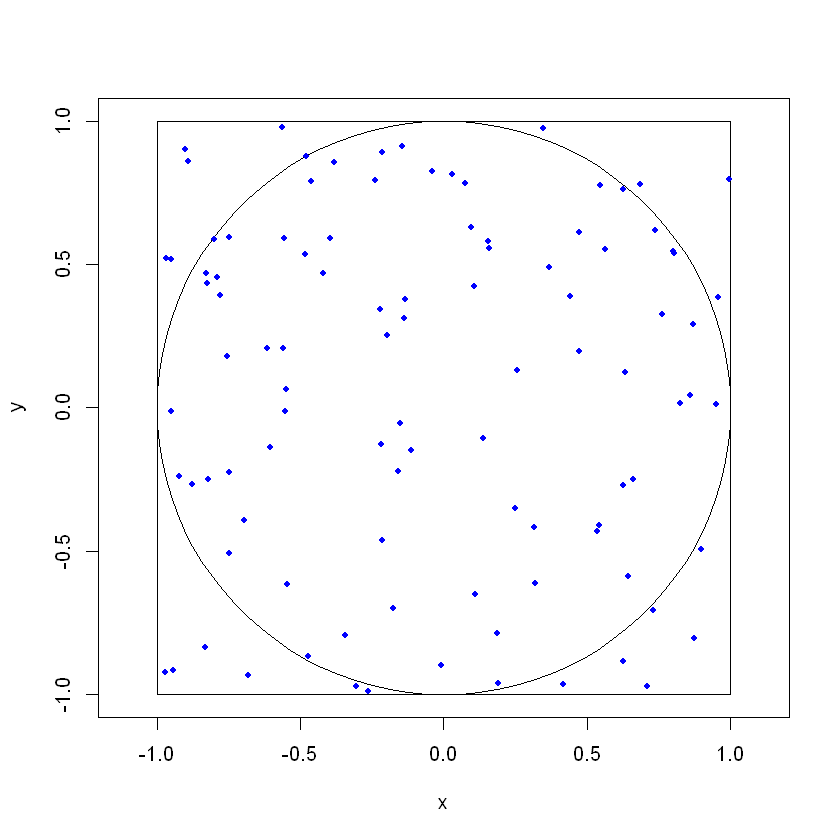

In [4]:
require(plotrix)
require(grid)

plot(c(-1, 1), c(-1, 1), type = "n", asp = 1, xlab = "x", ylab = "y")
rect(-1, -1, 1, 1)
draw.circle(0, 0, 1)
points(x = runif(100) * 2 - 1, y = runif(100) * 2 - 1, pch = 20, col = "blue")

By laws of large numbers, $\pi$ can be approximated by a stochastic algorithm

$$
E\left[\boldsymbol{1}\left\{ x^{2}+y^{2}\leq1\right\} \right] = \frac{\pi r^{2}}{\left(2r\right)^{2}}= \frac{\pi}{4}
$$

it implies  $\pi=4\times E[ 1 \{  x^{2}+y^{2}\leq1 \}]$. 

In [5]:
n <- 10000000
Z <- 2 * matrix(runif(n), ncol = 2) - 1 # uniform distribution in [-1, 1]

inside <- mean(sqrt(rowSums(Z^2)) <= 1) # the center of the circle is (0, 0)
cat("The estimated pi = ", inside * 4, "\n")


The estimated pi =  3.142574 


* Sample size can be made as large as the computer's memory permits.
* Iterate it with average of averages and so on, for higher accuracy.


## Writing Script

* A script is a piece of code for a particular purpose. Thousands of lines are not written from the beginning to the end. 

* Recursively development
  * small manageable tasks
  * test code constantly 
  * encapsulate into DIY functions
  

* Integrate small pieces into the super structure. 
* Add comments to the script to facilitate readability


## Finite Sample Evaluation

* Real world sample is finite
* Asymptotic theory is a mathematical apparatus to approximate finite sample distributions
* Modern econometric theory is built on asymptotics
* Simulation is one way to evaluate the accuracy of approximation.

## Example

For the OLS estimator, 

* Classical views $X$ as fixed regressions and only cares about the randomness of the error term.
* Modern econometrics textbook emphasizes that a random $X$ is more appropriate
for econometrics applications. 
* In rigorous textbooks, the moment of $X$ is explicitly stated as $E[X_i X_i'] < \infty$.

* A Pareto distribution with shape coefficient between 1 and 2 has finite population mean, but infinite variance. 
* If $X$ follows a
[Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution) with shape coefficient 1.5, it violates the assumptions for OLS stated in most of econometric textbooks.
* Question: Is asymptotic inferential theory for the OLS estimator valid? 

We write a script to investigate this problem. The following steps develop the code.

 1. given a sample size, get the OLS `b_hat` and its associated `t_value`.
 2. wrap `t_value` as a user-defined function so that we can reuse it for many times.
 3. given a sample size, report the size under two distributions.
 4. wrap step 3 again as a user-defined function, ready for different sample sizes.
 5. develop the super structure to connect the workhorse functions.
 6. add comments and documentation.


### $t$-statistic

$$
\sqrt{n} (\hat{\beta} - \beta_0) |X = (X'X/n)^{-1}  (X' e /\sqrt{n}),
$$

the $k$-th element of the vector coefficient conditional on $X$ is
$$
\widehat{\beta}_{k}|X=\eta_{k}'\widehat{\beta}|X
\sim N\left(\beta_{k},\sigma^{2}\left(X'X\right)_{kk}^{-1}\right).
$$

In [2]:
# the workhorse functions
simulation <- function(n, type = "Normal", df = df) {
  # a function gives the t-value under the null
  if (type == "Normal") {
    e <- rnorm(n)
  } else if (type == "T") {
    e <- rt(n, df)
  }

  X <- cbind(1, VGAM::rpareto(n, shape = 1.5))
  Y <- X %*% b0 + e
  rm(e)

  bhat <- solve(t(X) %*% X, t(X) %*% Y)
  bhat2 <- bhat[2] # parameter we want to test

  e_hat <- Y - X %*% bhat
  sigma_hat_square <- sum(e_hat^2) / (n - 2)
  sig_B <- solve(t(X) %*% X) * sigma_hat_square
  t_value_2 <- (bhat2 - b0[2]) / sqrt(sig_B[2, 2])

  return(t_value_2)
}


In [3]:
# report the empirical test size
report <- function(n) {
  # collect the test size from the two distributions
  # this function contains some repetitive code, but is OK for such a simple one
  TEST_SIZE <- rep(0, 3)

  # e ~ normal distribution, under which the t-dist is exact
  Res <- plyr::ldply(.data = 1:Rep, .fun = function(i) simulation(n, "Normal"))
  TEST_SIZE[1] <- mean(abs(Res) > qt(.975, n - 2))
  TEST_SIZE[2] <- mean(abs(Res) > qnorm(.975))

  # e ~ t-distribution, under which the exact distribution is complicated.
  # we rely on asymptotic normal distribution for inference instead
  Res <- plyr::ldply(.data = 1:Rep, .fun = function(i) simulation(n, "T", df))
  TEST_SIZE[3] <- mean(abs(Res) > qnorm(.975))

  return(TEST_SIZE)
}


In [4]:
## the super structure
# set the parameters
Rep <- 1000
b0 <- matrix(1, nrow = 2)
df <- 1 # t dist. with df = 1 is Cauchy

# run the calculation of the empirical sizes for different sample sizes
NN <- c(5, 10, 200, 5000)
RES <- plyr::ldply(.data = NN, .fun = report)
names(RES) <- c("exact", "normal.asym", "cauchy.asym") # to make the results readable
RES$n <- NN
RES <- RES[, c(4, 1:3)] # beautify the print
print(RES)


     n exact normal.asym cauchy.asym
1    5 0.057       0.161       0.151
2   10 0.043       0.082       0.092
3  200 0.057       0.060       0.027
4 5000 0.050       0.050       0.020


### Simulation Results

* 1st column: the error is normal, 
  * use exact distribution theory to find the critical value (according to $t$-distribution.)

* 2nd column: still uses the normal error
  * change the critical value to asymptotic normal distribution
  
* 3rd column: error distribution is Cauchy
  * asymptotic approximation breaks down
  * test size does not converge to the nominal 5%  

### Observations

* $X$ is always Pareto 
* we witness that the distribution of $X$ doesn't matter. 

### Justification


The $t$-statistic

$$
T_{k}  =\frac{\widehat{\beta}_{k}-\beta_{k}}{\sqrt{s^{2}\left[\left(X'X\right)^{-1}\right]_{kk}}} =\frac{\widehat{\beta}_{k}-\beta_{k}}{\sqrt{\sigma^{2}\left[\left(X'X\right)^{-1}\right]_{kk}}}\cdot\frac{\sqrt{\sigma^{2}}}{\sqrt{s^{2}}}\\
  =\frac{\left(\widehat{\beta}_{k}-\beta_{k}\right)/\sqrt{\sigma^{2}\left[\left(X'X\right)^{-1}\right]_{kk}}}{\sqrt{\frac{e'}{\sigma}M_{X}\frac{e}{\sigma}/\left(n-K\right)}}.
$$

* Self-normalized $t$ statistic does not break down despite that $X'X/n$ does not converge
* Regardless the distribution of $X$, when the error term is normal 
  * numerator follows $N(0,1)$
  * demonimator follows $\chi^2$

### World View


* Fundamental question: how to quantify uncertainty.
  * data $(X_1,X_2,\ldots,X_n)$
  * sample mean $\bar{X}$
  * sample variance $s$
  * frequentist confidence interval about the population mean

* Asymptotics is imaginary.
* Let's be realistic: we have a finite sample $n$.

## Bootstrap

* Let $X_1, X_2, \ldots, X_n \sim F$ be an i.i.d. sample of $n$ observations following a distribution $F$. 
* The finite sample distribution of a statistic $T_n(\theta)\sim G_n(\cdot, F)$ usually depends on the sample size $n$, as well as the known true distribution $F$. 


### Key idea

* Bootstrap replaces the unknown distribution $F$ in $G_n(\cdot, F)$ by the empirical distribution function

$$
\hat{F}_n(\cdot) = n^{-1} \sum_{i=1}^n 1\{\cdot \leq X_i\}
$$

* Bootstrap inference is drawn from the bootstrap distribution

$$
G_n(\cdot, \hat{F}_n)
$$



### Compare to Asymptotic theory

* Bootstrap is a finite-sample practice 
* It doesn't refer to an imaginary world where $n\to \infty$ at its face value


* Asymptotic theory approximates $G_n(\cdot, F)$ by its limit 

$$G(\cdot, F) := \lim_{n\to\infty} G_n(\cdot, F).$$ 

* if $T_n(\theta)$ is *asymptotically pivotal*, then $G_n(\cdot, F)$ is independent of $F$ and it becomes $G(\cdot)$.

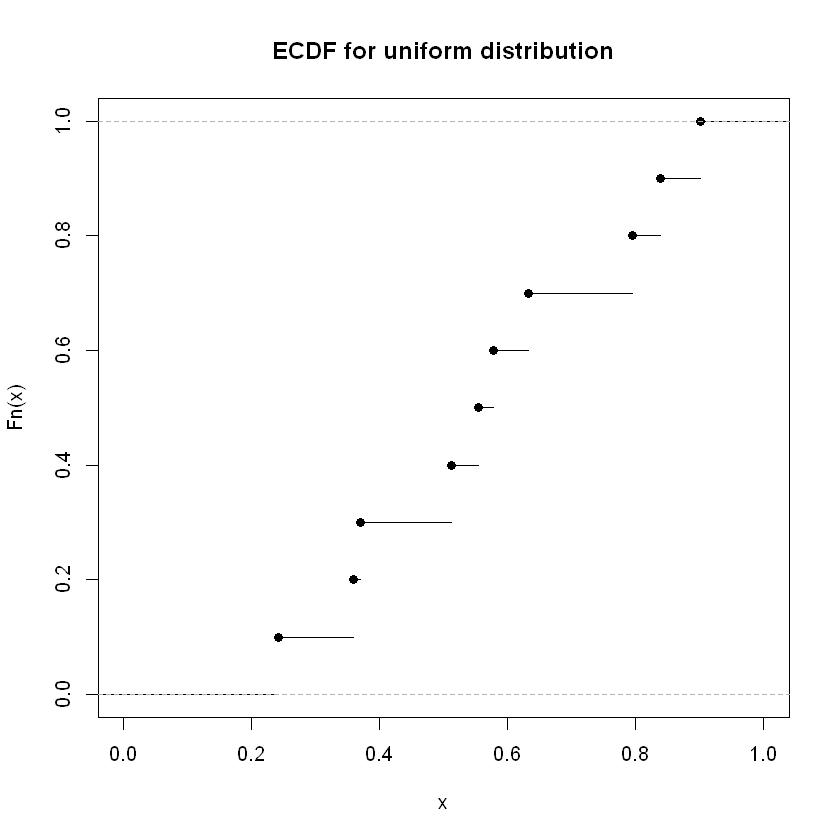

In [8]:
runif(10) %>%
  ecdf() %>%
  plot(, xlim = c(0, 1), main = "ECDF for uniform distribution")


### Nonparametric bootstrap

* Implementation of bootstrap is a simulation exercise. 
* In an i.i.d. environment, $n$ observations are drawn with equal weight and **with replacement** from the realized sample

### Variants of bootstrap schemes

* Block bootstrap: preserve dependence structure
  * dependent dataset such as time series
  * clustering data or networks

* parametric bootstrap
  * In regression context if we hold the independent variables fixed

* wild bootstrap: [[Davidson, 2010]](https://www.tandfonline.com/doi/abs/10.1198/jbes.2009.07221?journalCode=ubes20)
  * Heteroskedascity

In [9]:
n <- 9 # sample size
boot_Rep <- 3 # bootstrap 3 times

real_sample <- rnorm(n) # the real sample
d0 <- tibble(no = 1:n, x = real_sample)
print(d0)

d_boot <- list() # save the bootstrap sample
for (b in 1:boot_Rep) {
  boot_index <- sample(1:n, n, replace = TRUE)
  d_boot[[b]] <- tibble(no = boot_index, x = real_sample[boot_index])
}

d_boot %>% as_tibble(, .name_repair = "minimal") %>% print()

# A tibble: 9 × 2
     no      x
  <int>  <dbl>
1     1 -0.855
2     2 -1.20 
3     3 -0.335
4     4  0.366
5     5 -1.97 
6     6  0.629
7     7 -1.18 
8     8  1.96 
9     9 -0.801
# A tibble: 9 × 3
  ``$no     $x ``$no     $x ``$no     $x
  <int>  <dbl> <int>  <dbl> <int>  <dbl>
1     6  0.629     4  0.366     5 -1.97 
2     4  0.366     2 -1.20      7 -1.18 
3     3 -0.335     5 -1.97      4  0.366
4     2 -1.20      7 -1.18      4  0.366
5     4  0.366     4  0.366     1 -0.855
6     4  0.366     3 -0.335     5 -1.97 
7     4  0.366     9 -0.801     8  1.96 
8     5 -1.97      8  1.96      8  1.96 
9     6  0.629     1 -0.855     2 -1.20 


### Bootstrap Estimation


* R package [boot](http://cran.r-project.org/web/packages/boot/index.html) provides a general function `boot()`.
* `ply`-family functions for repeated simulations. 

* Bootstrap is convenient. 
  * Analytic formula of the variance of an econometric estimator can be complex to derive or code up.

## Example

* One of the most popular estimators for a sample selection model is @heckman1977sample's two-step method

* Outcome equation

$$
y_i = x_i \beta + u_i
$$

and the selection equation be

$$
D_i = z_i \gamma + v_i
$$

* To obtain a point estimator, we simply run a Probit in the selection model, predict the probability of participation, and then run an OLS of $y_i$ on $x_i$ and $\lambda (\hat{D}_i)$ in the outcome model, where $\lambda(\cdot)$ is the inverse Mill's ratio. 

* From Heckman (1979)'s original paper, the asymptotic variance expression of the two-step estimator is very complicated.

* Instead of following the analytic formula, we can simply bootstrap the variance.

In [12]:
# the dataset comes from
# Greene( 2003 ): example 22.8, page 786
library(sampleSelection)
data(Mroz87)
# equations
selection_eq <- lfp ~ -1 + age + faminc + exper + educ
outcome_eq <- wage ~ exper + educ

# Heckman two-step estimation
heck <- sampleSelection::heckit(selection_eq, outcome_eq, data = Mroz87)
print(lmtest::coeftest(heck))


Loading required package: maxLik

Loading required package: miscTools


Please cite the 'maxLik' package as:
Henningsen, Arne and Toomet, Ott (2011). maxLik: A package for maximum likelihood estimation in R. Computational Statistics 26(3), 443-458. DOI 10.1007/s00180-010-0217-1.

If you have questions, suggestions, or comments regarding the 'maxLik' package, please use a forum or 'tracker' at maxLik's R-Forge site:
https://r-forge.r-project.org/projects/maxlik/




z test of coefficients:

                 Estimate  Std. Error z value  Pr(>|z|)    
age           -3.8037e-02  4.7335e-03 -8.0357 9.306e-16 ***
faminc         1.0433e-05  4.3179e-06  2.4163   0.01568 *  
exper          7.4747e-02  7.1535e-03 10.4491 < 2.2e-16 ***
educ           6.3923e-02  1.6283e-02  3.9257 8.646e-05 ***
(Intercept)   -1.9611e+00  1.7375e+00 -1.1287   0.25904    
exper          1.6135e-02  3.3126e-02  0.4871   0.62619    
educ           4.8222e-01  8.0096e-02  6.0205 1.739e-09 ***
invMillsRatio -3.0237e-01  9.6202e-01 -0.3143   0.75328    
sigma          3.1080e+00          NA      NA        NA    
rho           -9.7290e-02          NA      NA        NA    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



* Below is the function for a single bootstrap. 

In [ ]:
n <- nrow(Mroz87)
boot_heck <- function() {
  indices <- sample(1:n, n, replace = T) # resample the index set
  Mroz87_b <- Mroz87[indices, ] # generate the bootstrap sample
  heck_b <- sampleSelection::heckit(selection_eq, outcome_eq, data = Mroz87_b)
  return(coef(heck_b))
}

* Implementation is just a repeated evaluation.

In [13]:
# repeat the bootstrap
boot_Rep <- 199
Heck_B <- plyr::ldply(.data = 1:boot_Rep, .fun = function(i) boot_heck())

# collect the bootstrap outcomes
Heck_b_sd <- apply(Heck_B, 2, sd)[1:7]
print(Heck_b_sd)

         age       faminc        exper         educ  (Intercept)        exper 
4.683937e-03 4.844919e-06 7.959621e-03 1.790120e-02 2.345574e+00 4.082622e-02 
        educ 
9.399000e-02 


* The standard errors from the analytical expression and those from bootstrap are comparable.
* The bootstrap estimates can also be used to directly compute the confidence intervals.


### Bootstrap Test

* Bootstrap is particularly helpful in inference

### Example

* test a hypothesis about the population mean. 

* a $t$-statistic
* Distribution of the sample is either
  * normal
  * zero-centered chi-square 

* We will show that the bootstrap test size is
more precise than that of the asymptotic approximation.


In [7]:
# the t-statistic for a null hypothesis mu
T_stat <- function(Y, mu) sqrt(n) * (mean(Y) - mu) / sd(Y)

# the bootstrap function
boot_test <- function(Y, boot_Rep) {
  # INPUT
  # Y: the sample
  # boot_Rep: number of bootstrap replications

  n <- length(Y)
  boot_T <- rep(0, boot_Rep)

  # bootstrap in action
  for (r in 1:boot_Rep) {
    indices <- sample.int(n, n, replace = T) # resampling the index
    resampled_Y <- Y[indices] # construct a bootstrap artificial sample
    boot_T[r] <- abs(T_stat(resampled_Y, mean(Y)))
    # the bootstrapped t-statistic
    # mu is replaced by "mean(Y)" to mimic the situation under the null
  }

  # bootstrap critical value
  boot_critical_value <- quantile(boot_T, 1 - alpha)
  # bootstrap test decision
  return(boot_critical_value)
}


### Bootstrap World

* The null hypothesis must be imposed no matter the hypothesized parameter is true value or not.

* Bootstrap $t$-statistic is

$$
T^{*}_{n} = \frac{\bar{X^{*}} - \bar{X}} { s^{*} / \sqrt{n} }.
$$



* It is centered at $\bar{X}$, the sample mean of $F_n$
* rather than $\theta$, the population mean of $F$. 
 
* In the bootstrap world the ``true`` distribution is $F_n$
* If we wrongly center the bootstrap t-statistic at $\theta$,
then the test will have no power when the null hypothesis is false.

The following chuck of code report the rejection probability from three decision rules.

In [8]:
compare <- function() {
  # this function generates a sample of n observations
  # and it returns the testing results from three decision rules

  if (distribution == "normal") {
    X <- rnorm(n)
  }
  else if (distribution == "chisq") {
    X <- rchisq(n, df = 3) - 3
  }

  t_value_X <- T_stat(X, mu) # T-statistic

  # compare it to the 97.5% of t-distribution
  exact <- abs(t_value_X) > qt(0.975, df = n - 1)
  # compare it to the 97.5% of normal distribution
  asym <- abs(t_value_X) > 1.96
  # decision from bootstrap
  boot_rule <- abs(t_value_X) > boot_test(X, boot_Rep)

  return(c(exact, asym, boot_rule))
}

In [9]:
# set the parameters
n <- 20
distribution <- "normal"
boot_Rep <- 199
MC_rep <- 2000
alpha <- 0.05
mu <- 0

# Monte Carlo simulation and report the rejection probability
res <- plyr::ldply(.data = 1:MC_rep, .fun = function(i) compare())
colnames(res) <- c("exact", "asym", "bootstrap")
print(colMeans(res))

    exact      asym bootstrap 
   0.0525    0.0670    0.0535 


### Results

* The program reports the empirical size.
* Nominal size of the test is 5%. 
* We find here the bootstrap test is more accurate


* When the underlying distribution is a $\chi^2$, the exact distribution is difficult 
to derive analytically. 
* However, we can still compare the asymptotic size with the bootstrap size.


In [10]:
distribution <- "chisq"

res <- plyr::ldply(.data = 1:MC_rep, .fun = function(i) compare())
colnames(res) <- c("exact?", "asym", "bootstrap")
print(colMeans(res))


   exact?      asym bootstrap 
    0.063     0.080     0.056 


* Here the "exact test" is no longer exact. 
* The asymptotic test works fairly reasonable
* the bootstrap is closer to the nominal size 5%.



## Reading

* Efron and Hastie: Ch 10 and 11
* ISLR: Ch 5.2